# Analysis of Abl mutations in Perses

Analysis of the Hauser et al. mutations for dasatinib and imatinib inhibitors

**Note:** Some simulations are still running for a number of mutations and so the dataset may be incomplete.

In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import notebook as tqdm_notebook
import pandas as pd


from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole

In [2]:
def subtract_offset(forward_work, reverse_work):

    print("--> subtracting offset")
    
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)
    
    return forward_work_offset, reverse_work_offset

In [3]:
def analyse(forward_accumulated, reverse_accumulated):
    
    print("--> computing dg, ddg")
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    
    return dg, ddg


In [4]:
def plot_works(forward_work_offset,
               reverse_work_offset,
               dg,
               ddg,
               phase,
               mutation,
               title,
               save=False,
               output_dir=None):
    
    CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    
    # Plot work trajectories
    # TODO: automatically determine the x axis -> this is a bit of a hack at the moment
    print("--> plotting work trajs")
    
    for i, cycle in enumerate(forward_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[0], label='forward')
        else:
            plt.plot(x, y, color=CB_color_cycle[0])
        
    for i, cycle in enumerate(reverse_work_offset):
        
        x = [(j+1)*12.1e-4 for j in range(len(list(cycle)))]
        y = -cycle
        if i==0:
            plt.plot(x, y, color=CB_color_cycle[1], label='reverse')
        else:
            plt.plot(x, y, color=CB_color_cycle[1])
        
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_traj.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_traj.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()
    
    # Plot work distributions
    print("--> plotting work distrib")
    
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward, color=CB_color_cycle[0], label='forward')
    sns.distplot(accumulated_reverse, color=CB_color_cycle[1], label='reverse')
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.legend(loc='best')
    if save:
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f"{mutation}_{phase}_work_dist.png"), dpi=500)
            print(f"--> saved to: {os.path.join(output_dir, f'{mutation}_{phase}_work_dist.png')}")
        else:
            print("--> No output_dir specified!")
    else:
        plt.show()
    plt.clf()

In [5]:
# 4xey dasatinib mutations
dasatinib_mutations = [
    'E255K', 'E255V', 'E355A', 'F317C', 'F317I',
    'F317L', 'F317V', 'F359C', 'F359I', 'F359V',
    'G250E', 'H396R', 'L248R', 'L248V', 'M244V',
    'M351T', 'T315A', 'T315I', 'V299L', 'Y253F'
    ]

imatinib_mutations = [
    'M244V', 'L248R', 'L248V', 'G250E', 'Y253F',
    'E255K', 'E255V', 'V299L', 'T315A', 'T315I',
    'F317C', 'F317I', 'F317L', 'F317V', 'M351T',
    'E355A', 'F359C', 'F359I', 'F359V', 'H396R',
    'E459K'
]

In [6]:
df = {}

for mutation in mutations:

    # Load and combine arrays
    forward_complex_arrays = []
    reverse_complex_arrays = []
    forward_apo_arrays = []
    reverse_apo_arrays = []

    for j in tqdm_notebook.tqdm(range(100)):

        #print(f"--> job: {j}")
        forward_complex_path = f'/data/chodera/glassw/kinoml/Abl/run_neq_NoTraj/4xey/{mutation}/4xey_dasatinib_{mutation}_complex_{j}_forward.npy'
        reverse_complex_path = f'/data/chodera/glassw/kinoml/Abl/run_neq_NoTraj/4xey/{mutation}/4xey_dasatinib_{mutation}_complex_{j}_reverse.npy'
        forward_apo_path = f'/data/chodera/glassw/kinoml/Abl/run_neq_NoTraj/4xey/{mutation}/4xey_dasatinib_{mutation}_apo_{j}_forward.npy'
        reverse_apo_path = f'/data/chodera/glassw/kinoml/Abl/run_neq_NoTraj/4xey/{mutation}/4xey_dasatinib_{mutation}_apo_{j}_reverse.npy'

        if os.path.exists(forward_complex_path):
            with open(forward_complex_path, 'rb') as f:
                forward_complex_arrays.append(np.load(f))

        if os.path.exists(reverse_complex_path):
            with open(reverse_complex_path, 'rb') as f:
                reverse_complex_arrays.append(np.load(f))

        if os.path.exists(forward_apo_path):
            with open(forward_apo_path, 'rb') as f:
                forward_apo_arrays.append(np.load(f))

        if os.path.exists(reverse_apo_path):
            with open(reverse_apo_path, 'rb') as f:
                reverse_apo_arrays.append(np.load(f))

    if forward_complex_arrays and reverse_complex_arrays and forward_apo_arrays and reverse_apo_arrays:

        forward_complex_combined = np.concatenate(forward_complex_arrays)
        forward_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_complex_combined]) # compute this separately bc the last value of the subsampled array is diff than the actual last sample
        forward_complex_combined = np.array([cycle for cycle in forward_complex_combined])
        print(forward_complex_combined.shape)

        reverse_complex_combined = np.concatenate(reverse_complex_arrays)
        reverse_complex_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_complex_combined])
        reverse_complex_combined = np.array([cycle for cycle in reverse_complex_combined])

        forward_apo_combined = np.concatenate(forward_apo_arrays)
        forward_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in forward_apo_combined])
        forward_apo_combined = np.array([cycle for cycle in forward_apo_combined])
        print(forward_apo_combined.shape)

        reverse_apo_combined = np.concatenate(reverse_apo_arrays)
        reverse_apo_accumulated = np.array([cycle[-1] - cycle[0] for cycle in reverse_apo_combined])
        reverse_apo_combined = np.array([cycle for cycle in reverse_apo_combined])


        # Analyse

        ## complex
        forward_complex_work_offset, reverse_complex_work_offset = subtract_offset(forward_complex_combined,
                                                                                   reverse_complex_combined)

        complex_dg, complex_ddg = analyse(forward_complex_accumulated,
                                          reverse_complex_accumulated)

        ## apo
        forward_apo_work_offset, reverse_apo_work_offset = subtract_offset(forward_apo_combined,
                                                                           reverse_apo_combined)

        apo_dg, apo_ddg = analyse(forward_apo_accumulated, reverse_apo_accumulated)

        ## plot the work trajectories and distibutions
        complex_plot = plot_works(forward_complex_work_offset,
                                  reverse_complex_work_offset,
                                  complex_dg,
                                  complex_ddg,
                                  phase='complex',
                                  mutation=mutation,
                                  title=f'4XEY-Dasatinib {mutation}',
                                  save=True,
                                  output_dir='/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output')

        apo_plot = plot_works(forward_apo_work_offset,
                              reverse_apo_work_offset,
                              apo_dg,
                              apo_ddg,
                              phase='apo',
                              mutation=mutation,
                              title=f'4XEY-Dasatinib {mutation}',
                              save=True,
                              output_dir='/lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output')

        ## Get binding dg and ddg
        binding_dg = complex_dg - apo_dg
        binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
        df[mutation] = [binding_dg, binding_ddg]
        print(f"--> complex_dg: {complex_dg}")
        print(f"--> apo dg: {apo_dg}")

    else:
        print(f"--> dir {mutation} has at least one phase without data" )


(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255K_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255K_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255K_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255K_apo_work_dist.png
--> complex_dg: 88.13278887022689
--> apo dg: 87.780638683229



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E255V_apo_work_dist.png
--> complex_dg: 167.51061087390414
--> apo dg: 166.40491329537141



(96, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E355A_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E355A_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E355A_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/E355A_apo_work_dist.png
--> complex_dg: 144.22325183167385
--> apo dg: 144.43374962832823



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317C_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317C_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317C_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317C_apo_work_dist.png
--> complex_dg: 25.796888742392305
--> apo dg: 23.160259820482068



(100, 1251)
(96, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317I_apo_work_dist.png
--> complex_dg: 27.700176516508524
--> apo dg: 24.355188621712536



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317L_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317L_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317L_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317L_apo_work_dist.png
--> complex_dg: 22.496068635091927
--> apo dg: 16.612852752236112



(94, 1251)
(85, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F317V_apo_work_dist.png
--> complex_dg: 45.93668684846123
--> apo dg: 42.37123555759635



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359C_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359C_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359C_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359C_apo_work_dist.png
--> complex_dg: 18.383535953946843
--> apo dg: 18.054830119185425



(96, 1251)
(96, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359I_apo_work_dist.png
--> complex_dg: 23.868517836618352
--> apo dg: 23.326503167934817



(79, 1251)
(83, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/F359V_apo_work_dist.png
--> complex_dg: 42.849051906935415
--> apo dg: 42.25824562961964



(100, 1251)
(98, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/G250E_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/G250E_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/G250E_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/G250E_apo_work_dist.png
--> complex_dg: -140.134425653294
--> apo dg: -140.14467150541165



--> dir H396R has at least one phase without data



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248R_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248R_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248R_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248R_apo_work_dist.png
--> complex_dg: 223.97787432349946
--> apo dg: 214.2589145572909



(99, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/L248V_apo_work_dist.png
--> complex_dg: -3.6164771546441825
--> apo dg: -4.01772452984385



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M244V_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M244V_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M244V_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M244V_apo_work_dist.png
--> complex_dg: 17.782103533197716
--> apo dg: 17.66686460262487



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M351T_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M351T_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M351T_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/M351T_apo_work_dist.png
--> complex_dg: 38.27548994506478
--> apo dg: 38.2686007304109



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315A_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315A_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315A_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315A_apo_work_dist.png
--> complex_dg: -38.43916600968556
--> apo dg: -42.790856479421876



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315I_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315I_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315I_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/T315I_apo_work_dist.png
--> complex_dg: 22.389351804090488
--> apo dg: 17.762215768105488



(92, 1251)
(58, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/V299L_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/V299L_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/V299L_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/V299L_apo_work_dist.png
--> complex_dg: 8.464391603207996
--> apo dg: 6.107978948285946



(100, 1251)
(100, 1251)
--> subtracting offset
--> computing dg, ddg
--> subtracting offset
--> computing dg, ddg
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/Y253F_complex_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/Y253F_complex_work_dist.png
--> plotting work trajs
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/Y253F_apo_work_traj.png
--> plotting work distrib
--> saved to: /lila/home/glassw/GITHUB/study-abl-resistance/notebooks/perses_analysis_output/Y253F_apo_work_dist.png
--> complex_dg: -0.7192513584570825
--> apo dg: -1.7977034149970241


<Figure size 432x288 with 0 Axes>

In [7]:
exp_df = pd.read_csv('../data/hauser_mutations.csv')

In [8]:
exp_df_dasatinib = exp_df[exp_df['tki'] == 'dasatinib']
exp_df_dasatinib

,tki,mutation,resid,from,to,IC50,ddG_exp
47,dasatinib,M244V,244,MET,VAL,2.0,0.00
48,dasatinib,L248R,248,LEU,ARG,6.0,0.65
49,dasatinib,L248V,248,LEU,VAL,5.0,0.55
50,dasatinib,G250E,250,GLY,GLU,4.0,0.41
51,dasatinib,Y253F,253,TYR,PHE,3.0,0.24
52,dasatinib,E255K,255,GLU,LYS,9.0,0.90
53,dasatinib,E255V,255,GLU,VAL,11.0,1.02
54,dasatinib,V299L,299,VAL,LEU,16.0,1.24
55,dasatinib,T315A,315,THR,ALA,59.0,2.02
56,dasatinib,T315I,315,THR,ILE,10000.0,5.08


In [27]:
pddf = pd.DataFrame(df).T
pddf = pddf * KT_KCALMOL
pddf.columns = ["DDG (kcal / mol)", "dDDG (kcal / mol)"]

# manually adding experimental values for now...
#exp_DDG = [0.9, 1.02, 0.24, 1.86, 1.79, 0.96, 2.36, 0.00, 0.24, 0.00, 0.41, 0.65, 0.55, 0.00, 0.00] 
exp_DDG = [exp_df_dasatinib[exp_df_dasatinib['mutation'] == mutation]['ddG_exp'].item() 
           for mutation in list(pddf.index)]

pddf['exp_DDG (kcal / mol)'] = exp_DDG 
pddf['|DDG - exp_DDG|'] = (pddf['DDG (kcal / mol)'] - pddf['exp_DDG (kcal / mol)']).abs()
pddf

,DDG (kcal / mol),dDDG (kcal / mol),exp_DDG (kcal / mol),|DDG - exp_DDG|
E255K,0.209939,0.277074,0.90,0.690061
E255V,0.659175,0.262779,1.02,0.360825
E355A,-0.125491,0.264248,0.24,0.365491
F317C,1.571858,0.098109,1.86,0.288142
F317I,1.994155,0.165579,1.79,0.204155
F317L,3.507350,0.216107,0.96,2.547350
F317V,2.125587,0.162702,2.36,0.234413
F359C,0.195962,0.215981,0.00,0.195962
F359I,0.323129,0.174067,0.24,0.083129
F359V,0.352216,0.256454,0.00,0.352216


In [28]:
pddf.to_csv("4xey_dasatinib_DDGs.csv")

## Plotting

taken from: https://github.com/openforcefield/Arsenic/blob/master/arsenic/plotting.py, credit: `@hannahbrucemacdonald`

In [29]:
import scipy
from sklearn.metrics import mean_squared_error, mean_absolute_error

def stats(true_sample, predicted_sample, statistic):
    
    if statistic == 'RMSE':
            return np.sqrt(mean_squared_error(true_sample, predicted_sample))
    elif statistic == 'MUE':
        return mean_absolute_error(true_sample, predicted_sample)
    elif statistic == 'R2':
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true_sample, predicted_sample)
        return r_value**2
    elif statistic == 'rho':
        return scipy.stats.pearsonr(true_sample, predicted_sample)[0]

In [30]:
x = pddf['exp_DDG (kcal / mol)'].values
y = pddf['DDG (kcal / mol)'].values
yerr = pddf['dDDG (kcal / mol)'].values

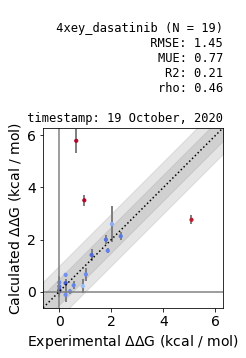

In [32]:
from datetime import date
today = date.today()
figsize=5

fig, ax = plt.subplots(figsize=(figsize, figsize))


# aesthetics
font_size = 14
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['font.size'] = font_size
plt.subplots_adjust(left=0.2, right=0.7, bottom=0.2, top=0.7)


plt.xlabel('Experimental $\Delta\Delta$G (kcal / mol)')
plt.ylabel(r'Calculated $\Delta\Delta$G (kcal / mol)')

ax_min = min(min(x), min(y)) - 0.5
ax_max = max(max(x), max(y)) + 0.5
scale = [ax_min, ax_max]

plt.xlim(scale)
plt.ylim(scale)

# plots x-axis and y-axis
origins=True
if origins:
    plt.plot([0, 0], scale, 'gray')
    plt.plot(scale, [0, 0], 'gray')

# plots x=y line
plt.plot(scale, scale, 'k:')
guidelines=True

if guidelines:
    small_dist = 0.5
    # plots grey region around x=y line
    plt.fill_between(scale, [ax_min - small_dist, ax_max - small_dist],
                     [ax_min + small_dist, ax_max + small_dist],
                     color='grey', alpha=0.2)
    plt.fill_between(scale, [ax_min - small_dist * 2, ax_max - small_dist * 2],
                     [ax_min + small_dist * 2, ax_max + small_dist * 2],
                     color='grey', alpha=0.2)
# actual plotting
cm = plt.get_cmap('coolwarm')

#if color is None:
color = np.abs(x-y)
# 2.372 kcal / mol = 4 RT
color = cm(color / 2.372)

plt.errorbar(x, y, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
plt.scatter(x, y, color=color, s=10, marker='o', zorder=2)

# stats and title
statistics_string = ''
for statistic in ['RMSE', 'MUE', 'R2', 'rho']:
    s = np.round(stats(x, y, statistic=statistic), 2)
    string = f"{statistic}: {s}\n"
    statistics_string += string

title = ''
target_name = '4xey_dasatinib'
long_title = f'{title} \n {target_name} (N = {len(y)})\n {statistics_string} \n timestamp: {today.strftime("%d %B, %Y")}'
plt.title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')


plt.savefig('4xey_dasatinib_exp_vs_calc.png', dpi=300)

In [33]:
pwd

'/lila/home/glassw/GITHUB/study-abl-resistance/notebooks'